In [1]:
import path_planning as pp
import matplotlib.pyplot as plt
from pso import PSO
import os
import imageio.v2 as imageio
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
plt.rcParams["figure.autolayout"] = True

In [3]:
# Create 3D environment
env_params = {
    'width': 100,
    'height': 100,
    'depth': 100,
    'robot_radius': 1,
    'start': [10, 10, 10],  # Red start
    'goal': [90, 90, 90],   # Green goal
}
env = pp.Environment(**env_params)

In [4]:
# Updated obstacle configuration
obstacles = [
    # Far left wall (forces strong rightward movement)
    {'center': [15, 25, 30], 'radius': 14},  # Lower left
    {'center': [10, 60, 50], 'radius': 12},  # Upper left
    
    # Far right wall (forces strong leftward movement)
    {'center': [85, 35, 60], 'radius': 16},  # Middle right
    {'center': [90, 65, 40], 'radius': 10},  # Upper right
    
    # Vertical challenge (must go above/below)
    {'center': [50, 50, 20], 'radius': 18},  # Low center
    {'center': [50, 50, 80], 'radius': 18}   # High center
]

# Clear existing obstacles and add new ones
env.clear_obstacles()  # Add this method to your Environment class if missing
for obs in obstacles:
    env.add_obstacle(pp.Obstacle(**obs))

In [5]:
# Create cost function
num_control_points = 5  # More points for complex 3D navigation
resolution = 75         # Higher resolution for smoother paths
cost_function = pp.create_cost_function(env, num_control_points, resolution)

# Optimization Problem
problem = {
    'num_var': 3 * num_control_points,
    'var_min': 0,
    'var_max': 100,
    'cost_function': cost_function,
}

In [6]:
# Enhanced callback with custom colors
def callback(data):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_box_aspect([1, 1, 1])  # Equal axis scaling
    
    # Plot environment with custom colors
    ax.scatter(*env.start, color='red', s=150, label='Start', depthshade=False)
    ax.scatter(*env.goal, color='green', s=150, label='Goal', depthshade=False)
    
    # Plot SOLID BLACK spheres with transparency
    for obs in env.obstacles:
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]  # Higher resolution mesh
        x = obs.center[0] + obs.radius * np.cos(u) * np.sin(v)
        y = obs.center[1] + obs.radius * np.sin(u) * np.sin(v)
        z = obs.center[2] + obs.radius * np.cos(v)
        
        # Solid black surface with 50% opacity
        ax.plot_surface(x, y, z, color='black', alpha=0.5, edgecolor='k', linewidth=0.3)
    
    if isinstance(data['gbest']['details']['sol'], pp.SplinePath3D):
        sol = np.array(data['gbest']['details']['sol'].control_points)  # Extract control points
    else:
        sol = np.array(data['gbest']['details']['sol']).reshape((-1, 3))  # Reshape only if it's an array
        
    path_obj = pp.SplinePath3D(env, sol, resolution)
    path = path_obj.get_path()
    ax.plot(path[:,0], path[:,1], path[:,2], color='#6ba7cc', linewidth=4, linestyle='-', marker='o', markersize=3, markerfacecolor='blue')
        
    # Add markers for control points
    ax.scatter(sol[:,0], sol[:,1], sol[:,2], color='orange', s=50, marker='o', label='Control Points')
    
    # Add info and legend
    ax.set_title(f"Iteration: {data['it']}, Length: {data['gbest']['details']['length']:.2f}")
    ax.view_init(elev=35, azim=-45)  # Optimal viewing angle
    ax.set_xlim(0, 100); ax.set_ylim(0, 100); ax.set_zlim(0, 100)  # Clear boundaries
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.tight_layout()
    
    # Save frame
    plt.savefig(f'pso_3d_frames/frame_{data["it"]:03d}.png', dpi=100)
    plt.close()


**PSO**

In [14]:
# Run PSO with tuned parameters
# Create directory for pso frames
os.makedirs('pso_3d_frames', exist_ok=True)
pso_params = {
    'max_iter': 80,
    'pop_size': 60,
    'c1': 2.0,
    'c2': 1.8,
    'w': 0.7,
    'wdamp': 0.99,
    'resetting': 15,
}
bestsol, pop = PSO(problem, callback=callback, **pso_params)


Iteration 1: Best Cost = 306.311682504732
Iteration 2: Best Cost = 272.1399177132444
Iteration 3: Best Cost = 253.63364305258392
Iteration 4: Best Cost = 230.7091462001763
Iteration 5: Best Cost = 228.60893684712326
Iteration 6: Best Cost = 225.48611591261803
Iteration 7: Best Cost = 223.46939298009585
Iteration 8: Best Cost = 223.46939298009585
Iteration 9: Best Cost = 223.46939298009585
Iteration 10: Best Cost = 223.46939298009585
Iteration 11: Best Cost = 223.46939298009585
Iteration 12: Best Cost = 223.46939298009585
Iteration 13: Best Cost = 223.35594123643213
Iteration 14: Best Cost = 223.35594123643213
Resetting particles...
Iteration 15: Best Cost = 223.35594123643213
Iteration 16: Best Cost = 223.35594123643213
Iteration 17: Best Cost = 223.35594123643213
Iteration 18: Best Cost = 223.35594123643213
Iteration 19: Best Cost = 223.35594123643213
Iteration 20: Best Cost = 223.35594123643213
Iteration 21: Best Cost = 223.35594123643213
Iteration 22: Best Cost = 223.35594123643213


In [15]:
# Create video
images = []
for it in range(1, pso_params['max_iter']+1):
    filename = f'pso_3d_frames/frame_{it:03d}.png'
    if os.path.exists(filename):
        images.append(imageio.imread(filename))
imageio.mimsave('pso_3d_animation.mp4', images, fps=10)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 900) to (1200, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
# ===== INTERACTIVE VIEWER =====
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])  # Fix sphere distortion

# Plot final optimized path
if isinstance(bestsol['details']['sol'], pp.SplinePath3D):
    final_control_points = np.array(bestsol['details']['sol'].control_points)  # Extract control points
else:
    final_control_points = np.array(bestsol['details']['sol']).reshape((-1, 3))  # Reshape if it's a NumPy array
    
path_obj = pp.SplinePath3D(env, final_control_points, resolution=150)  # Higher resolution for smooth display
path = path_obj.get_path()

# Visual elements
ax.scatter(*env.start, color='red', s=200, label='Start')
ax.scatter(*env.goal, color='green', s=200, label='Goal')
ax.plot(path[:,0], path[:,1], path[:,2], 'b-', linewidth=4, label='Optimal Path')

# Draw perfect black spheres
for obs in env.obstacles:
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]  # High-res spheres
    x = obs.center[0] + obs.radius * np.cos(u) * np.sin(v)
    y = obs.center[1] + obs.radius * np.sin(u) * np.sin(v)
    z = obs.center[2] + obs.radius * np.cos(v)
    ax.plot_surface(x, y, z, color='black', alpha=0.6, edgecolor='none')

# Labels and legend
ax.set_xlabel('X Axis'); ax.set_ylabel('Y Axis'); ax.set_zlabel('Z Axis')
ax.set_title('Final 3D Path Solution (Click & Drag to Rotate)')
ax.legend()

# Set initial view angle
ax.view_init(elev=25, azim=-80) 

plt.tight_layout()
plt.show()  # This makes the window interactive!

print("3D animation saved with enhanced visualization!")

**RRT**

In [13]:
from rrt import RRT, rrt_callback
import os

# Run RRT
os.makedirs('rrt_frames', exist_ok=True)
rrt = RRT(env, max_nodes=1000, step_size=10)
path = rrt.plan(callback=lambda data: rrt_callback(env, data))

In [14]:
images = []
for fname in sorted(os.listdir('rrt_frames')):
    if fname.endswith('.png'):
        images.append(imageio.imread(f'rrt_frames/{fname}'))
imageio.mimsave('rrt_animation.mp4', images, fps=10)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1440, 1080) to (1440, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


**A Star**

In [7]:
# In your main script:
from a_star import AStar3D, astar_callback

os.makedirs('astar_frames', exist_ok=True)

# Run A* with visualization
astar = AStar3D(env)
path = astar.plan(callback=lambda data: astar_callback(env, data))

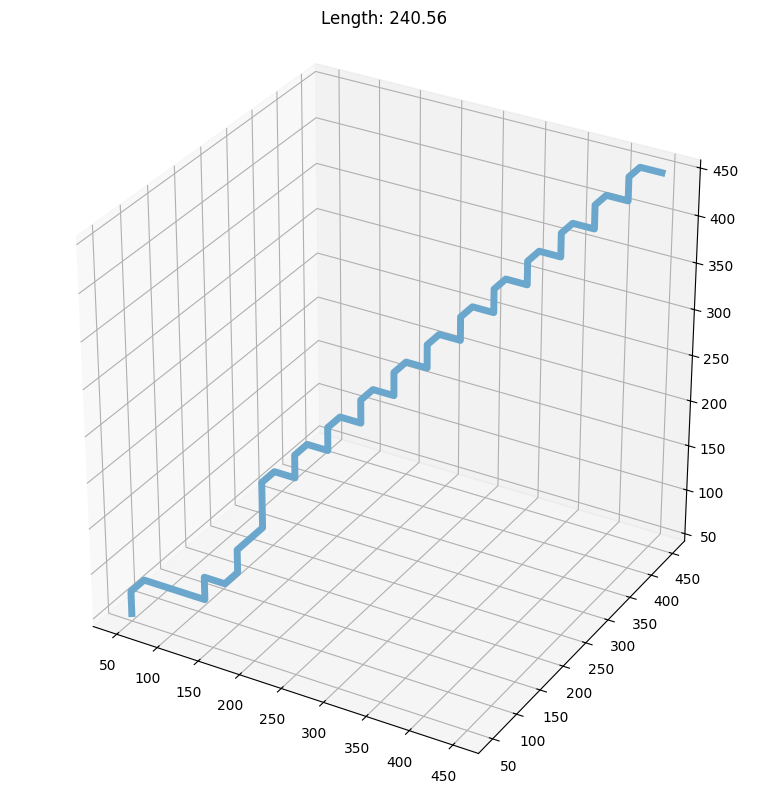

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])
if path is not None:
    ax.plot(path[:,0], path[:,1], path[:,2], color='#6ba7cc', linewidth=5, label='Final Path')

plt.title("Length: 240.56")
plt.show()

In [9]:
images = []
frame_files = sorted(os.listdir('astar_frames'), key=lambda x: int(x.split('_')[-1].split('.')[0]))

for filename in frame_files:
    filepath = os.path.join('astar_frames', filename)
    images.append(imageio.imread(filepath))

if images:
    imageio.mimsave('astar_3d_animation.mp4', images, fps=10, format='FFMPEG')
    print("A* animation saved as astar_3d_animation.mp4")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 900) to (1200, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


A* animation saved as astar_3d_animation.mp4
